In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

import os, PIL

import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.random.set_seed(1)

import pathlib

In [2]:
data_dir = 'data'

data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*')))

print('图片总数为:', image_count)

图片总数为: 4000


In [4]:
batch_size = 2
img_height = 299
img_width = 299

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=2,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=2,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4000 files belonging to 4 classes.
Using 3200 files for training.
Found 4000 files belonging to 4 classes.
Using 800 files for validation.


In [6]:
class_names = train_ds.class_names

print(class_names)

['cat', 'chook', 'dog', 'horse']


In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(2, 299, 299, 3)
(2,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds.cache()
    .shuffle(1000)
#    .map(train_preprocessing)
#    .batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds.cache()
    .shuffle(1000)
#    .map(val_preprocessing)
#    .batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

In [9]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Activation, Conv2D, SeparableConv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions

def Xception(input_shape=[299, 299, 3], classes=1000):
    img_input = Input(shape=input_shape)

    #=================#
    #   Entry flow
    #=================#
    #  block1
    # 299,299,3 -> 149,149,64
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1')(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    # block2 深度可分离卷积=深度卷积(3x3CNN)+逐点卷积(1x1CNN)--->实现更少的参数 更少的运算量
    # 149,149,64 -> 75,75,128
    residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv1_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
    x = layers.add((x, residual))

    # block3
    # 75,75,128 -> 38,38,256
    residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block3_pool')(x)
    x = layers.add([x, residual])

    # block4
    # 38,38,256 -> 19,19,728
    residual = Conv2D(728, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block4_pool')(x)
    x = layers.add([x, residual])

    #=================#
    # Middle flow
    #=================#
    # block5--block12
    # 19,19,728 -> 19,19,728
    for i in range(8):
        residual = x
        prefix = 'block' + str(i+5)

        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix+'_sepconv1')(x)
        x = BatchNormalization(name=prefix+'_sepconv1_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix+'_sepconv2')(x)
        x = BatchNormalization(name=prefix+'_sepconv2_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix+'_sepconv3')(x)
        x = BatchNormalization(name=prefix+'_sepconv3_bn')(x)

        x = layers.add([x, residual])

    #=================#
    #    Exit flow
    #=================#
    # block13
    # 19,19,728 -> 10,10,1024
    residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x)
    x = Activation('relu', name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
    x = layers.add([x, residual])

    # block14
    # 10,10,1024 -> 10,10,2048
    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = Activation('relu', name='block14_sepconv1_act')(x)

    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = Activation('relu', name='block14_sepconv2_act')(x)

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    inputs = img_input
    model = Model(inputs, x, name='xception')

    return model

In [10]:
model = Xception()

model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv1_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [11]:
initial_learning_rate = 1e-4

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=300,
    decay_rate=0.96,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [12]:
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 1115s 692ms/step - accuracy: 0.4356 - loss: 1.3482 - val_accuracy: 0.5038 - val_loss: 1.2204
Epoch 2/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 1017s 635ms/step - accuracy: 0.6078 - loss: 0.9357 - val_accuracy: 0.6125 - val_loss: 1.0118
Epoch 3/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 996s 622ms/step - accuracy: 0.7125 - loss: 0.7214 - val_accuracy: 0.6538 - val_loss: 1.0182
Epoch 4/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 961s 601ms/step - accuracy: 0.8447 - loss: 0.4404 - val_accuracy: 0.7038 - val_loss: 0.7942
Epoch 5/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 958s 599ms/step - accuracy: 0.9453 - loss: 0.1939 - val_accuracy: 0.6662 - val_loss: 0.9861
Epoch 6/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 958s 599ms/step - accuracy: 0.9750 - loss: 0.1020 - val_accuracy: 0.7050 - val_loss: 0.8698
Epoch 7/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 959s 599ms/step - accuracy: 0.9941 - loss: 0.0396 - val_accuracy: 0.7075 - val_loss: 0.8987
Epoch 8/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 958s 599ms/step - 

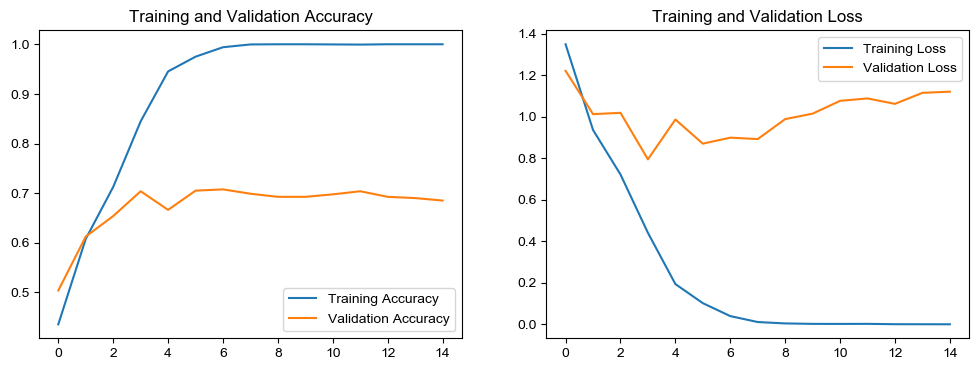

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def plot_cm(labels, predictions):
    conf_numpy = confusion_matrix(labels, predictions)
    conf_df = pd.DataFrame(conf_numpy, index=class_names, columns=class_names)

    plt.figure(figsize=(8, 7))
    sns.heatmap(conf_df, annot=True, fmt='d', cmap='BuPu')
    plt.title('混淆矩阵:', fontsize=15)
    plt.ylabel('真实值:', fontsize=14)
    plt.xlabel('预测值:', fontsize=14)

In [17]:
val_pre = []
val_label = []

for images, labels in val_ds:
    for image, label in zip(images, labels):
        img_array = tf.expand_dims(image, 0)
        prediction = model.predict(img_array)
        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━

2025-08-27 14:46:45.274831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


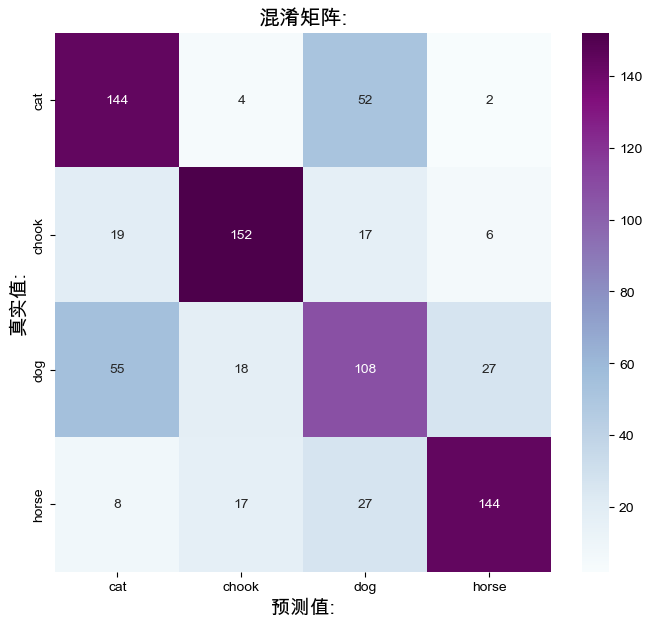

In [19]:
plot_cm(val_label, val_pre)

In [ ]:
model.save('23_model.h5')

new_model = tf.keras.models.load_model('23_model.h5')